# From Jupyter Notebook to Web Server: Containerizing Interactive Visualizations

<strong>The purpose of this notebook is to provide an example of how one could use an existing interactive visualization in a Jupyter notebook file to create a container version that could be hosted on the web. The hope is that the content provides a path where it could be applied to other similar notebooks and open up avenues to create containers and interactive web content to compliment the notebooks.</strong>

## Prerequisites

**Note:** If Docker is already installed there is a container image available that contains everything else. It can be launched via the following command : `docker run --privileged -p 8888:8888 docker.io/ncote/podman-notebook:v2 jupyter lab --ip 0.0.0.0`

In order to work through this example on your local machine make sure you have installed the following programs

* [Python](https://wiki.python.org/moin/BeginnersGuide/Download)
* [pip](https://pip.pypa.io/en/stable/installation/)
* [nbconvert](https://nbconvert.readthedocs.io/en/latest/install.html) included in [Jupyter Notebook](https://docs.jupyter.org/en/latest/install/notebook-classic.html) or [JupyterLab](https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html)
* [Git](https://git-scm.com/book/en/v2/Getting-Started-Installing-Git)
* [Mamba](https://github.com/conda-forge/miniforge#install)
* [Podman](https://podman.io/docs/installation) or [Docker](https://docs.docker.com/engine/install/)

Confirm all are correctly installed by running the following cells, or the cell contents in a terminal window, and the output should be the installed version. If you get a message that the command is not found check your installation and restart your terminal, or this notebook, to make sure changes are loaded correctly. 

In [ ]:
!python3 --version

In [ ]:
!git --version

In [ ]:
!mamba --version

In [ ]:
!podman --version

**Note:** There is a section on creating a [GitHub Action](https://docs.github.com/en/actions) to build the container and push it to Docker Hub. This requires a [GitHub account](https://github.com/signup?ref_cta=Sign+up&ref_loc=header+logged+out&ref_page=%2F&source=header-home), a [Docker Hub account](https://hub.docker.com/signup), and for the [example repository to be forked](https://github.com/NicholasCote/nbviz-to-container/fork). 

## Convert the notebook to run locally as a web server

### Project Pythia examples

[Project Pythia Cookbooks](https://cookbooks.projectpythia.org/) are a great resource for example workflows built with Jupyter Notebooks. Here is a [link to an existing cookbook](https://projectpythia.org/interactive-sentinel-2-cookbook/README.html) authored by [Pritam Das](https://github.com/pritamd47) that contains an interactive visualization to use in this example.  

### Copy the notebook content

In order to get started the notebook files need to be copied in to the working directory. That can be accomplished with git clone as seen in the example below. Running the cell will also add the repository contents to the working directory as well. 

In [ ]:
!git clone https://github.com/pritamd47/interactive-sentinel-2.git

There is now a directory named interactive-sentinel-2 with the repository contents in the current working directory. The notebook that contains the interactive visualization can be found at [interactive-sentinel-2/notebooks/data-intake-ms-planetary-computer.ipynb](interactive-sentinel-2/notebooks/data-intake-ms-planetary-computer.ipynb). 

### Convert notebook to Python

The notebook itself can not be run as a web server, but the interactive visualization is built with the Python package [Panel](https://panel.holoviz.org/) which can run a web server. The Jupyter Notebook package contains a CLI tool that can be used to convert notebooks to a Python script. The cell below can be run to do this, or the content can be copied to the command line and run individually.

In [ ]:
!jupyter nbconvert --to python interactive-sentinel-2/notebooks/data-intake-ms-planetary-computer.ipynb

A Python script of the notebook now exists at [interactive-sentinel-2/notebooks/data-intake-ms-planetary-computer.py](interactive-sentinel-2/notebooks/data-intake-ms-planetary-computer.py)

### Organize web app files

Before changing file content let's create a directory for the web app and copy in the content needed to run everything. The cell below can be run to do this, or the content can be copied to the command line and run individually.

In [ ]:
!mkdir interactive-web-app
!cp interactive-sentinel-2/notebooks/data-intake-ms-planetary-computer.py interactive-web-app/app.py
!cp interactive-sentinel-2/environment.yml interactive-web-app/environment.yml

There is now a interactive-web-app directory that contains the Python packages required, in environment.yml, and the notebook that was converted to a Python script which was renamed in the copy to app.py. 

### Install and activate Conda environment

The `interactive-web-app/environment.yml` file contains all the Python packages required to run the application. It can be installed with Mamba by running the following cell or copying the contents to a terminal prompt and running it directly.

In [ ]:
!mamba env create -f interactive-web-app/environment.yml

```{note}
Mamba is used here instead of conda because it is optimized to install the packages faster. It will still take some time to install everything, wait until it is complete to move on.
```

When the installation is complete the following message will be displayed:

```shell
#
# To activate this environment, use
#
#     $ conda activate is2-cookbook-dev
#
# To deactivate an active environment, use
#
#     $ conda deactivate
```

In order to utilize the packages installed it's required to activate the environment with the command shown above first. 

```{note}
Running `conda activate` inside a notebook can be problematic and moving forward running commands in a separate terminal shell will be required. 
```

`conda activate is2-cookbook-dev`

The command line should now look like this:

```shell
(is2-cookbook-dev) ncote@cisl-lagrange:~/Code/nbviz-to-container$
```

```{note}
If you get a message that conda is not initialized for your shell follow the instructions presented for your system and restart the shell before trying again.
```

### Edit app.py & run as web server

In order to run the Python script as a web server only one thing needs to be added, `.servable()`. Open the app.py file and scroll all the way to the bottom. Line 304 contains a single closed parenthesis, `)`. Add `.servable()` after the closed parenthesis and lines 301-304 in the new code will look like this:

```python
pn.Column(
    pn.Row(winter_plot, spring_plot),
    pn.Row(summer_plot, fall_plot)
).servable()
```

Save the file. It can now be tested as a local web server by running the following command in the activated conda environment:

```shell
(is2-cookbook-dev) ncote@cisl-lagrange:~/Code/nbviz-to-container$ panel serve interactive-web-app/app.py
```

After that command has been run the output will show that there is a Bokeh app running at: [http://localhost:5006/app](http://localhost:5006/app). The link can be used to navigate directly to the website but it will take awhile to load initially. In the terminal window there will now be additional output as the application starts a local Dask cluster and computes everything required for the application. 

```{note}
Because we are simplifying this process for the purposes of running a workshop the underlying code is still optimized to run as a notebook with in depth explanations. In reality we would want to spend more time optimizing the Python script to run as a web server.
```

When the initial startup is complete the site will display 4 interactive visualizations of satellite imagery of the NSF NCAR Mesa Lab at various dates the user can select via a slider. It will look like this:

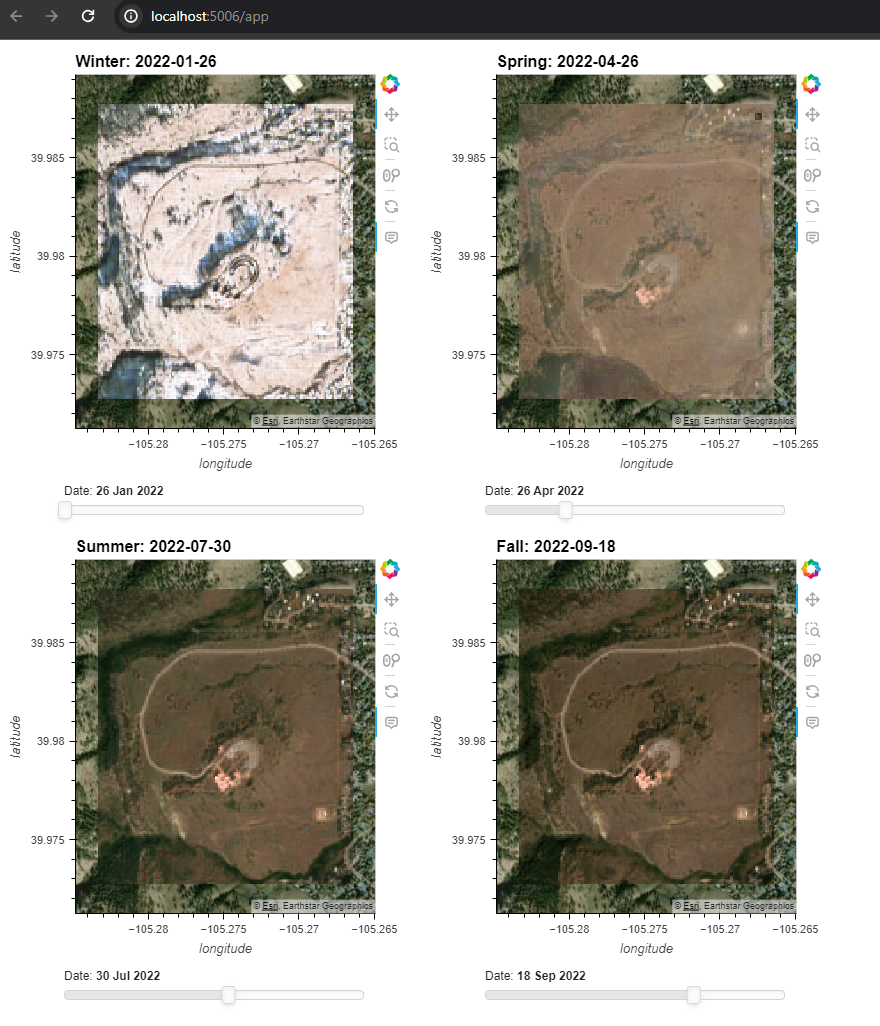

Hold `Ctrl + C` to stop the web server and exit back to the shell.

## Build the application in a container

### An Introduction to Containers

Containers package software and dependencies into a single image that can be run on any platform with a container engine installed. The image is portable and immutable, the software inside won't change. It will reliably run in the same state years from now making it powerful for easy reproducibility. 

### Create the container image file

A container image file, popularly referred to as a Dockerfile, is a set of instructions on how to build and run an application. The next step is to create a Containerfile and add in the instructions required. Create a new file named Containerfile in the current working directory in whatever fashion you are most comfortable with. The contents of the Containerfile are shown below with comments inline to explain what each line does. 

```docker
# Use an official Mamba image as the base image
FROM docker.io/mambaorg/micromamba:latest

# Set the user to root for file copies and ownership
USER root

# Set the working directory in the container to /home/mambauser/app
WORKDIR /home/mambauser/app

# Copy the interactive-web-app directory contents into the container at /home/mambauser/app
COPY --chown=mambauser interactive-web-app/app.py interactive-web-app/environment.yml .

# Install any needed packages specified in requirements.yml
# Activate the environment by providing ENV_NAME as an environment variable at runtime 
RUN micromamba env create -f environment.yml

# Make port 5006 available for access outside this container
EXPOSE 5006

# Switch to mambauser for the running image
USER mambauser

# Set the command to run when the container is run
CMD ["panel", "serve", "--port", "5006", "app.py", "--allow-websocket-origin=*"]
```

Copy these instructions in to the Containerfile created above and save it. In total only 8 lines are required to setup what is required to run the application in a container. 

### Build the container image

With the container image build instructions in place a command can now be run to build it. The command below is an example of building an image in the ncote project with the name nbviz2cntnr. When running this command the image tag, `-t`, should be updated to something that makes sense for you. 

`podman build -f Containerfile -t ncote/nbviz2cntnr . --format=docker`

```{note}
With podman you do not need to specify a file name with `-f Containerfile` but that is included in case the file was named something else. By default podman will recognize files named `Dockerfile` or `Containerfile` without having to specify the location. Docker only recognizes `Dockerfile` so if this was built with docker instead of podman the `-f` flag would be required. The flag `--format=docker` is included as some of the lines used in the instructions are not in the OCI format and some shell commands will be ignored without it. 
```

It will take a few minutes for the image to build. When it is complete the output will look something like the following:

```shell
Successfully tagged localhost/ncote/nbviz2cntnr:latest
33df1d75d984069ed2a5200abb27cddd040c14766a221d2c121712df39a7b337
```

### Run the container image locally

Now that the image has been built it can also be ran locally to test functionality. The following command will run the container and make it accessible on the same URL as used before, [http://localhost:5006/app](http://localhost:5006/app).

`podman run -e ENV_NAME=is2-cookbook-dev -p 5006:5006 ncote/nbviz2cntr`

Because the container is built on top of mamba, and a custom conda environment has been installed, it's required to provide the environment name to activate when launching the container image. This is done with the `-e ENV_NAME=is2-cookbook-dev` flag. The port exposed in the container is also mapped to a port on the host machine with `-p 5006:5006`

The site is now accessible at the same URL but is running inside a container. The image that was built can be put in to a container registry. The CISL Cloud Pilot hosts a private registry at [https://hub.k8s.ucar.edu/](https://hub.k8s.ucar.edu/) and provides instructions that can be found at this [link to container registry documentation](https://ncar.github.io/cisl-cloud/how-to/K8s/harbor/harbor-intro.html).

## A note about on-premise cloud deployment and automation

Once there is a working container image that runs a web server locally it can be used in a number of different places, including as the content for a website at a live URL. Automation with GitHub Actions can be utilized to build a new image when changes are made and update configuration files, known as a [Helm chart](https://helm.sh/), to use the newest image. The Helm chart directory in the repository can be connected to a Continuous Delivery tool called [Argo CD](https://argoproj.github.io/cd/) which enables automatic synchronization The NSF NCAR CISL On-premise Cloud Pilot is setup to host these kinds of workloads and only requires a set of configuration files known as a [Helm chart](https://helm.sh/).

### Helm chart

In order to run the container on the CISL On-premise Cloud Pilot, a Kubernetes (K8s) cluster, a collection of 3 different K8s objects need to be created. The objects can be bundled together in to a Helm chart, a collection of templates that use custom values to define an applications. The 3 different K8s objects that are required are a [deployment](https://kubernetes.io/docs/concepts/workloads/controllers/deployment/), [service](https://kubernetes.io/docs/concepts/services-networking/service/), and [ingress](https://kubernetes.io/docs/concepts/services-networking/ingress/). A K8s deployment is the actual application running in 1 or more Pods. The K8s service exposes the Pod to the K8s internal network. Lastly the K8s ingress maps the service to a FQDN and exposes it outside the cluster. There are shared services running on the K8s cluster that will assign DNS records and valid certificates to provide a resolvable URL that is secured via HTTPS. In a Helm chart the K8s object definitions can be setup to take variables defined in a values.yaml file allowing for customization. 

#### Simple Web App Template

There is a simple web application Helm chart template available at this [link to web-app-helm repository](https://github.com/NicholasCote/web-app-helm). The web-app-helm directory included in the repo can be copied in to the repository that contains the container image and application code. Inside the web-app-helm directory is a file named values.yaml that needs to be updated with all the custom values required for your application. The README file included in the template repository contains instructions on what needs to be updated and what values to provide. A general overview of what is required to customize the values.yaml file is as follows:

1. A Name for your application, this is not the URL that will be deployed but the name of the k8s objects created
2. A URL path. This also is not the full URL, just the suffix you'd like to use after `.edu`. This is typically just `/` but may be things like `/api` that correspond to endpoints on your application.
3. An FQDN. This is the full URL for your application. Currently in the CISL cloud environment we only can create names under the `.k8s.ucar.edu` domain and your FQDN should end with `.k8s.ucar.edu`. Please make sure this is unique, try to browse to it before applying, and descriptive for your application. 
4. Container image to use. This should be an image that is already built and has been pushed to a container registry that the application can pull from. By default it is set to look at docker.io so if you are using something different you need to specify that before your container registry and image name:tag
5. Container port to expose. Your containerized application will expose a port to the network in order to communicate. More often than not there is a default for the application you are using and you also have the ability to provide a specific port if you wanted. If you have run your container image locally it is usually in the URL you used to access it locally, ie. `http://127.0.0.1:8888` is running on port 8888 and would be the appropriate value to put in the Helm chart. 

### GitHub Actions

A [GitHub Actions](https://docs.github.com/en/actions) workflow can be created to build a container when changes are made to a repository. This job can be run on GitHub provided machines, called runners, or self-hosted runners that can be run on a users machine or a central compute system like the CISL On-premise Cloud Pilot. YAML files define each workflow and are stored at the base of the repository in a directory named `.github/workflows/`.

#### GitHub provided runner example

The following example uses a GitHub provided machine running Ubuntu with predefined Actions built by Docker to run certain jobs. The image created is pushed to [Docker Hub](https://hub.docker.com/) and uses credentials stored as repository [Actions secrets](https://docs.github.com/en/actions/security-guides/using-secrets-in-github-actions) to login. Explanations of each line, or group of lines, are provided as comments in the example seen below:

```yaml
# Name the Action
name: Automation to build a container image
# Define when the Action is run. This example is run when there is a push to the flask-app/ directory on the app branch.
on:
  push:
    paths:
      - flask-app/**
    branches:
      - app
# Define the jobs to run. A job can have multiple steps and an Action can contain multiple jobs. 
jobs:
  build-image:
    # Use the latest ubuntu image to run the jobs
    runs-on: ubuntu-latest
    steps:
      # Step 1 is to checkout the github repo used to build the Dockerfile
      - name: Check out the repo
        uses: actions/checkout@v3
      # Step 2 is to login to docker hub so the image can be pushed
      - name: Login to Docker Hub
        uses: docker/login-action@v2
        # GitHub repository secrets are used as variables to provide login information to Docker Hub
        with:
          username: ${{ secrets.DOCKERHUB_USERNAME }}
          password: ${{ secrets.DOCKERHUB_TOKEN  }}
      # Get the date and send to GITHUB_OUTPUT to apply as image tag
      - name: Get current date
        id: date
        run: echo "date=$(date +'%Y-%m-%d.%H')" >> $GITHUB_OUTPUT
      # Build and push the docker image
      - name: Build Docker image
        uses: docker/build-push-action@v4
        with:
          # Provide the current directory as build context 
          context: .
          # Specify where the Dockerfile is located in relation to the repo base path
          file: Dockerfile
          # Enable the push to docker hub
          push: true
          # Provide the tags to apply to the image, this example uses the latest image tag 
          tags: |
            ncote/docker-example:${{ steps.date.outputs.date }}
```

#### Self-hosted runner example

```{note}
The self-hosted runner example depends on resources that currently are only available on the UCAR internal network. A VPN connection or access onsite at a UCAR facility is required to successfully run the commands and Action example. 
```

I have built a custom container image to do rootless podman builds and the configuration information can be found at this [link to my github-runner repository](https://github.com/NicholasCote/github-runner). The up to date container image is stored on the NSF NCAR CISL On-premise Cloud private container registry running on Harbor. In order to run the self-hosted runner on your local machine a GitHub API token is required when the container is launched. If you do not have an existing token use this [link to create an API token](https://github.com/settings/tokens). The example below uses a local environment variable, ${GITHUB_RUNNER_TOKEN}, instead of supplying the token as plain text in the command:

`podman run -e REPO={user/org}/{repo_name} -e TOKEN=${GITHUB_RUNNER_REGISTRATION} hub.k8s.ucar.edu/ncote/github-runner:2024-04-03.21`

Replace {user/org}/{repo_name} with the repository you want to connect the runner to, i.e. NicholasCote/nbviz-to-container. When run this will pull down the runner container image and start it automatically. There are a few prompts that will come up, the default value can be used for each one. Once those settings are entered there will be a confirmation that the runner is connected to GitHub and is Listening to Jobs. A GitHub action workflow that utilizes self-hosted runners can now be added and executed. Explanations of each line, or group of lines, are provided as comments in the example seen below:

```yaml
# This workflow builds container images and pushes them to the NSF NCAR Harbor Container Repository
# Set the workflow name
name: GitHub Runner Build, Push, & Update

# Define the trigger that starts the action
# For this workflow the trigger is on a push that changes anything in the main branch
on:
  - push

# Define the actions that are going to take place as part of this workflow    
jobs:
  # Name the job(s)
  build-push-gh-runner-cicd:
    # Define where the job should run in this case it will be run on the self-hosted runner image
    runs-on: self-hosted
    # Set the steps to take in order
    steps:
      # Step 1 is to checkout the github repo used to build the container image
      - name: Check out the repo
        uses: actions/checkout@v4
      # Get the date to apply to image tag
      - name: Get current date
        id: date
        run: echo "date=$(date +'%Y-%m-%d.%H.%M')" >> $GITHUB_OUTPUT
      # Use podman to build the image and tag it with the current date
      - name: Build and push image
        run: podman build -t hub.k8s.ucar.edu/ncote/github-runner:${{ steps.date.outputs.date }} .
      # Login to Harbor with a robot account for the ncote project in Harbor
      - name: Login to Harbor
        run: podman login hub.k8s.ucar.edu -u robot-ncote+ncote -p ${{ secrets.HARBOR_ROBOT_PW  }}
      # Push the image to Harbor
      - name: Push image to Harbor
        run: podman push hub.k8s.ucar.edu/ncote/github-runner:${{ steps.date.outputs.date }}
      # Update the Helm chart values.yaml file to use the new image and tag
      - name: Update Helm values.yaml
        run: | 
          sed -i '12d' gh-runner-helm/values.yaml
          echo "    image: hub.k8s.ucar.edu/ncote/github-runner:${{ steps.date.outputs.date }}" >> gh-runner-helm/values.yaml
      # Update the Helm Chart.yaml file to set the appVersion to be the image tag or date & time it was built
      - name: Update Helm Chart.yaml
        run: | 
          sed -i '24d' gh-runner-helm/Chart.yaml
          echo "appVersion: '${{ steps.date.outputs.date }}'" >> gh-runner-helm/Chart.yaml
      # Commit the changes made to the Helm chart and push them
      # Requires the repository settings for Actions -> General update to allow Read and write permissions for workflows 
      - name: Commit & push changes to main branch
        run: |
          git config --global user.email "$GITHUB_ACTOR@users.noreply.github.com"
          git config --global user.name "$GITHUB_ACTOR"
          git commit -a -m "Update Helm chart via GH Actions"
          git push
```

```{note}
In this example, Workflow permissions need to be changed in the GitHub repository Settings under Actions -> General. Update the Workflow permissions to be Read and write to allow the Action to make changes to the repository.
``` 

This workflow will run whenever there's changes and build a new container image. That image will be pushed to an internal container registry and the applications Helm chart will be updated to use the new image. If the Helm chart is connected to the CISL On-premise clouds [Argo CD instance](https://ncar.github.io/cisl-cloud/how-to/K8s/Hosting/deploy.html) it will automatically sync the changes and the site will be updated a few minutes after the changes have been made. 